# Project 1 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 1월 29일(일)
- 제출 내용: `4. 구현` 셀에 `LRClassifier` 변수를 구현하고, `Project1.ipynb`를 제출
- 제출 방법: `wisechang1@snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 1`
- 점수 비중: `Project 1 : Project 2 = 1 : 2`


### 채점 기준 [총 100점]
1. `5. 테스트` 셀이 잘 실행되어야 합니다. [+100점]
2. `LRClassifier`는 Logistic Regression을 이용해서 분류를 수행해야 합니다. [-100점]
3. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `4. 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. Project 1에서 성능은 채점 기준에 들어가지 않습니다.
2. `sklearn` 외의 다른 라이브러리를 사용해도 됩니다.

---
## 목차
1. 프로젝트 개요
2. 데이터<br/>
  2.1. 데이터 로드 방법<br/>
  2.2. 데이터 개요<br/>
  2.3. 데이터 샘플 예제<br/>
3. `KNNClassifier` 예제
4. 구현
5. 테스트

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-lg-2023-spring/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### 2. 데이터
#### 2.1. 데이터 로드
- 아래와 같은 방법을 통해 `pandas.DataFrame` 포맷의 데이터를 얻을 수 있습니다.

In [35]:
import pickle

BASE_DIR = '.'

with open(f'{BASE_DIR}/data/train.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(3)

,Subject,Data,Motion
0,3,"[[-2.115489959716797, 2.9105000495910645, 8.15...",ironing
1,3,"[[-3.5734200477600098, 3.9679501056671143, 10....",ironing
2,3,"[[-1.7668700218200684, 11.98840045928955, 1.08...",ironing


#### 2.2. 데이터 개요
- 각 샘플은 `Subject`, `Data`, `Motion` 값으로 이루어져 있습니다.
  - `Subject`: 실험자 ID (`int` 타입)
  - `Data`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Motion`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...

- `Data` 정보를 가지고 `Motion` 값을 유추해야합니다.
- `Subject`는 Cross Validation에 활용하기 위해 제공됩니다. Cross Validation의 경우 `CrossValidation.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

(13940, 500, 3)


/tmp/ipykernel_14546/3637493237.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


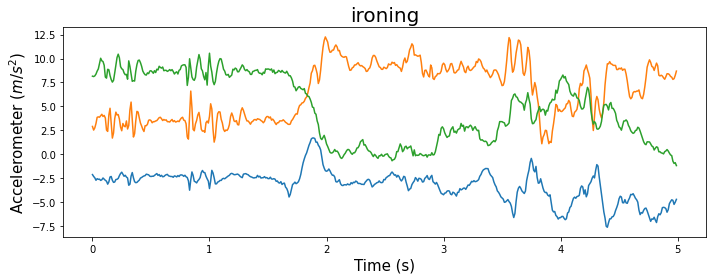

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
groups = np.stack(df['Subject'])  # For LeaveOneGroupOut
print(X.shape)
X_sample, Y_sample = X[0], Y[0]  # First X - y pair
time_stamps = np.arange(0, 5, 1/100)                 # Time stamps for 100Hz * 5seconds

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_stamps, X_sample)
ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
fig.tight_layout()
fig.show()

### 3. `KNNClassifier` 예제
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다. 채점기준을 참고해주세요.

```python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.
KNNClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier()),
])
```

#### `KNNClassifier` 구현 순서
##### a. `extract_features_from_a_single_sample`
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 추가적인 특성들을 구현할 때 아래 목록을 참고하실 수 있습니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

##### b. 전처리기 (Preprocessor) 추가
- a.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [`sklearn.preprocessing` documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.


##### c. 분류기 튜닝
- a.에서 어떤 특성을 사용할지, b.에서 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.

### 4. 구현

In [90]:
############################################################
# Implement your own LRClassifier in this cell

import math
from scipy import signal
from scipy.stats import kurtosis
from scipy.signal import butter, sosfilt, sosfreqz, hilbert, detrend,lfilter
from scipy.integrate import simps
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import StandardScaler



class cal_acc_distance():
    def __init__(self, signal):
        self.signal = signal.T
        
    def run_modules(self):
        l2_result = self.cal_norm(order=2)
        distance_features = np.hstack([l2_result])
        return distance_features

    def cal_norm(self,order):
        norm_list = [np.linalg.norm((self.signal[i, :] - self.signal[j, :]), ord=order) for i in range(0, self.signal.shape[0]-1) for j in range(i+1, self.signal.shape[0])]
        return np.asarray(norm_list).reshape(-1, self.signal.shape[0])


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    Fs = 100

    NFFT = len(X_sample)
#     k = np.arange(NFFT)
#     T = NFFT/Fs
#     frq = (k*Fs)/NFFT 
#     frq = frq[range(math.trunc(NFFT/2))] # single sied frequency range
#     Y = np.fft.fft(X_sample, NFFT, axis=0) 
#     Y = Y[range(math.trunc(NFFT/2))][1:]
#     fft_y = abs(Y)
    
    magnitudes = np.abs(np.fft.rfft(X_sample, axis=0)) # magnitudes of positive frequencies
    freqs = np.abs(np.fft.fftfreq(NFFT, 1.0/Fs)[:NFFT//2+1])
    fft_std = np.std(magnitudes, axis=0)

    centroid = np.sum(np.dot(freqs, magnitudes), axis=0) / np.sum(magnitudes,axis=0)


    c_corr = np.corrcoef(X_sample.T)
    
    corr_xy = c_corr[0,1]
    corr_xz = c_corr[0,2]
    corr_yz = c_corr[1,2]
    
    corr = np.hstack([corr_xy, corr_xz, corr_yz])
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    rms = np.sqrt(np.mean(np.abs(X_sample), axis=0))
    variance = np.var(X_sample, axis=0)
    kur = kurtosis(X_sample, axis=0)

    dist_features = cal_acc_distance(signal=X_sample).run_modules().reshape(-1)
    features = np.hstack([mean, std, corr, dist_features, centroid,fft_std])
    
    
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


print(extract_features_from_multiple_samples(X_samples=X).shape)
LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression()),
])

logit_grid = {'classifier__penalty': ['l1','l2'],
             'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear'],
             'classifier__C': np.logspace(-3,3,7)}

logo = LeaveOneGroupOut()
clf = GridSearchCV(LRClassifier, param_grid=logit_grid, scoring='f1_macro', cv=logo, n_jobs=-1, error_score=0)

clf = clf.fit(X, Y, groups=groups)
print(f'Best Parameters: {clf.best_params_}')

LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(C=clf.best_params_['classifier__C'],
                                      solver=clf.best_params_['classifier__solver'],
                                      penalty=clf.best_params_['classifier__penalty'])),
])


(13940, 18)


/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/nas/scratch/PR/hyunchan.moon/venv/torch

/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increa

/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

Best Parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cg'}


### 5. 테스트

In [91]:
# Import Libraries
import pickle
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

BASE_DIR = '.'

# Data Load
with open(f'{BASE_DIR}/data/train.pkl', 'rb') as f:
    df = pickle.load(f)

X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
groups = np.stack(df['Subject'])  # For LeaveOneGroupOut


# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

/nas/scratch/PR/hyunchan.moon/venv/torch_vs_tele/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


0.5313291015468624
